In [7]:
# Backward Euler Method
using LinearAlgebra
function backeuler(::Type{T}, a, b, u0, N) where T<:AbstractFloat
    u::Vector{T}=zeros(N+1)
    dt=(b-a)/N
    t=Vector{T}(range(a, b, N+1))
    A=1 .- cos.(t) *dt # A is Generated by Backward Euler method for du/dt=t^2 *u
    u[1]=u0
    for i in 1:N
        u[i+1]=u[i]/A[i]
    end
    return t, u
end

backeuler (generic function with 1 method)

In [8]:
# Modified Parareal method in mixed (Single and Double) precision
function mixmodparareal(a, b, u0, N, F, G, K)
    # a= start time value (t0)
    # b= End time value (tend)
    # N= Number of Subinterval
    # u0=initial Solution
    # F= Fine Solver
    # G= Coarse Solver
    # K= Parareal iteration
    
    tval=Vector(range(a, b, N+1))
    # Storing Fine Solution on each time step for comparison
    Ufine=Vector{Float64}(undef, N+1)
    Ufine[1]=u0
    for i in 1:N
        Ufine[i+1]=F(Float64, tval[i], tval[i+1], Ufine[i])
    end
    # Initializing Uk
    Uk=[Vector{Float64}(undef, N+1) for k in 1:K+1]
    #Storing the initial solution
    for k in 1:K+1
        Uk[k][1]=u0
    end
    # Parareal Initialization
    for j in 1:N
        #Uk[1][j+1]=G(tval[j], tval[j+1], Uk[1][j])
        Uk[1][j+1]=Float32(10)
    end
    # Parareal loop
    δUk=[Vector{Float32}(undef, N+1) for k in 1:K+1]
    for k in 1:K
        for i in 1:N
            δUk[k][i]=Uk[k+1][i]-Uk[k][i]
            Fk0=F(Float64,tval[i], tval[i+1], Uk[k][i])
            Gk=G(Float32, tval[i], tval[i+1], δUk[k][i])
            
            Uk[k+1][i+1]=Fk0 + Gk
        end
    end
    
    return Uk, Ufine, tval, δUk
  
end

mixmodparareal (generic function with 1 method)

In [9]:
function mmfinesol(Float64, a, b, u0)
    t, u=backeuler(Float64, a, b, Float64(u0), nF)
    return u[end]
end

mmfinesol (generic function with 1 method)

In [10]:
function mmcoarsesol(Float32, a, b, u0)
    t, u=backeuler(Float32, a, b, Float32(u0), nG)
    return u[end]
end

mmcoarsesol (generic function with 1 method)

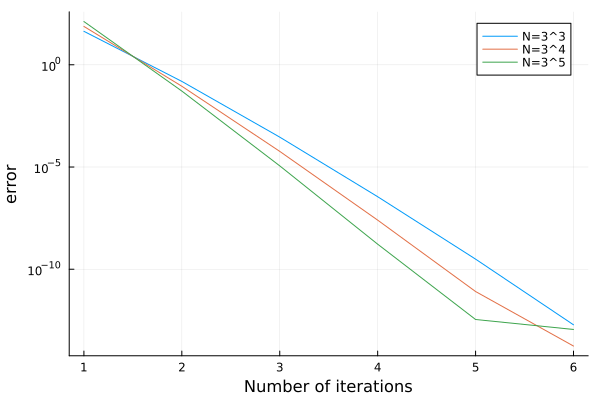

In [11]:
a=0
b=1
u0=1

#exact=exp.((t.^3)/3)


nF=500 # Fine grid
nG=5# Coarse grid
K=5 # Number of iteration


p = 3
N = zeros(p)
for i in 1:p
    N[i] = Int(floor(3^(i+2)))
end

err=zeros(p, K+1)
# Parareal Solution
for i in 1:p
    Uk, Ufine, tval, δUk=mixmodparareal(a, b, u0, convert(Int, N[i]), mmfinesol, mmcoarsesol, K)

    # stroing errors
    
    for k in 1:K+1
        err[i, k]=norm(Uk[k]-Ufine)
    end
end

using Plots
plot(err[1,:], yaxis=:log, xlabel="Number of iterations", ylabel="error", label="N=3^3")
for j in 2:p
    plot!(err[j,:], yaxis=:log, xlabel="Number of iterations", ylabel="error", label="N=3^$(j+2)")
end
display(plot!(legend=:topright))